In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

## Data load

In [2]:
# data load
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


### label encoding

In [3]:
# label encoding
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

class_dict = {}
for idx, class_name in enumerate(CLASS_NAMES):
    class_dict[class_name] = idx

train_data['class'] = train_data['class'].apply(lambda s: class_dict[s])

train_data.head()

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


## Preprocessing

In [4]:
# 중복 확인
train_data[train_data.duplicated(["class", "conversation"])]

,idx,class,conversation
392,392,3,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...
523,523,2,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...
789,789,3,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...
824,824,3,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...
869,869,2,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...
...,...,...,...
3797,3797,3,너 이번 방학 때 쌍꺼풀 수술 하고왔지?\n아닌데?\n아니긴 뭐가 아니야. 눈이 이...
3798,3798,3,안녕하세요 지금 먹방 촬영중인데 촬영가능할까요?\n안돼요\n한번만 안될까요?\n안돼...
3855,3855,3,그 소문 진짜야? 너가 다른 애들 뒷담화하고 다녔다며?\n응? 나 그런 적 없는데?...
3874,3874,3,야 니 왤캐 못생겼냐?\n뭐라그랬냐?\n으 나 보고 말하지마 니 얼굴보면 토나올거 ...


In [5]:
# 중복 제거
train_data = train_data.drop_duplicates(subset=["class", "conversation"])
train_data[train_data.duplicated(["conversation"])]

,idx,class,conversation


In [6]:
# reindexing
train_data = train_data.reset_index(drop=True)
train_data['idx'] = [x for x in range(len(train_data))]
train_data

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3841,3841,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3842,3842,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3843,3843,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3844,3844,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


## Augmentation

In [7]:
import random
import pickle
import re

wordnet = {}
with open("wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText = re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))
    
	# sr
	#for _ in range(num_new_per_technique):
	#	a_words = synonym_replacement(words, n_sr)
	#	augmented_sentences.append(' '.join(a_words))

	# ri
	#for _ in range(num_new_per_technique):
	#	a_words = random_insertion(words, n_ri)
	#	augmented_sentences.append(' '.join(a_words))
    
	# rs *
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# rd *
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences


<>:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_909/3990812560.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  words = [word for word in words if word is not ""]


In [8]:
class_ls = []
augcon_ls = []
for i in range(len(train_data['conversation'])):
    class_ = train_data['class'][i]
    num_aug = 5 # 2: 3배
    augcon = EDA(train_data['conversation'][i], num_aug=num_aug)
    for j in range(num_aug):
        class_ls.append(int(class_))
        augcon_ls.append(augcon[j])
        
    #if i == 2 : break

In [9]:
len(class_ls)

19230

In [10]:
aug_data = pd.DataFrame([class_ls, augcon_ls],
                  index=['class','conversation'],
                 columns=[x for x in range(len(class_ls))])
aug_data = aug_data.transpose()

In [11]:
aug_data

,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 아닙니다. 죽을 거면 혼자 죽지 우리까지 사건...
1,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 사건에 죽을 거면 혼자...
2,0,지금 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죽을 거면 죽지 우리까지 ...
3,0,지금 죽여버리고 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n...
4,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
...,...,...
19225,2,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...
19226,2,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...
19227,2,시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일했니?\n네 여름이라 기...
19228,2,희정씨\n네?\n주말에 칠한건데.\n희정씨가 시간이 왜그러세요?\n손이 빤짝빤짝 네...


In [12]:
test_ = train_data.append(aug_data)
test_['idx'] = [x for x in range(len(test_))]
test_ = test_.reset_index(drop=True)

In [13]:
test_[test_.duplicated(["class", "conversation"])]
test_[test_.duplicated(["class", "conversation"])]
test_ = test_.drop_duplicates(subset=["class", "conversation"])
test_ = test_.drop(columns = 'idx')
test_['class'] = test_['class'].astype('int64')


In [14]:
test_

,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...
23069,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...
23071,2,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...
23072,2,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...
23073,2,시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일했니?\n네 여름이라 기...


In [15]:
# 불용어 제거
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)
    
    sentence = sentence.strip()

    return sentence

In [16]:
# tokenizing
import sentencepiece as spm

def generate_spm_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # sentencepiece train을 위해 해당 corpus를 별도 파일로 만듬.
    temp_file = f"{lang}_corpus.txt"
    with open(temp_file, "w") as f:
        for sen in corpus:
            f.write(sen)
            f.write("\n")
    
    #  sentencepiece train
    model_name = f"{lang}_spm"
    spm.SentencePieceTrainer.train(input=temp_file, 
                                   model_prefix=model_name, 
                                   vocab_size=vocab_size, 
                                   pad_id=pad_id, 
                                   bos_id=bos_id, 
                                   eos_id=eos_id, 
                                   unk_id=unk_id)
    
    #  sentencepiece load
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name + ".model")
    
    return tokenizer

In [17]:
corpus = test_['conversation']

In [18]:
corpus = [preprocess_sentence(s) for s in corpus]

In [19]:
corpus[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 ? 진짜 죽여버리고 싶게 . 정말 잘못했습니다 . 너가 선택해 . 너가 죽을래 네 가족을 죽여줄까 . 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 . 선택 못하겠습니다 . 한번만 도와주세요 . 그냥 다 죽여버려야겠군 . 이의 없지 ? 제발 도와주세요 .'

In [20]:
len_list = list(map(lambda s: len(s), corpus))
print(max(len_list))
print(min(len_list))

909
8


In [21]:
test_['conversation'] = [preprocess_sentence(s) for s in corpus]

In [22]:
test_.head()
test_

,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,0,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...
2,3,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,1,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,1,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...
...,...,...
23069,1,누구맘대로 여기서 장사하래 ? 이게 무슨일입니까 ? 남의 구역에서 장사하려면 자릿세...
23071,2,희정씨 네 ? 주말에 시간이 넘쳐나나봐 갑자기 왜그러세요 ? 손이 빤짝빤짝 네일했니...
23072,2,희정씨 네 ? 주말에 시간이 넘쳐나나봐 갑자기 왜그러세요 ? 손이 빤짝빤짝 네일했니...
23073,2,시간이 넘쳐나나봐 갑자기 왜그러세요 ? 손이 빤짝빤짝 네일했니 ? 네 여름이라 기분...


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_wh

<AxesSubplot:ylabel='Count'>

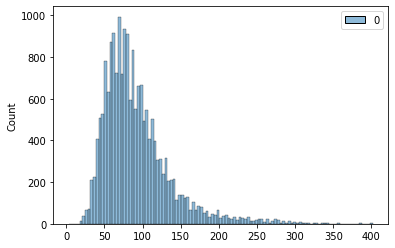

In [23]:
vocab_size = 10000

spm_tokenizer = generate_spm_tokenizer(corpus, vocab_size)
tokenized_corpus = []

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in range(len(corpus)):
    tokenized_corpus.append(spm_tokenizer.EncodeAsIds(corpus[idx]))
    
len_tokenized = [map(lambda s: len(s), tokenized_corpus)]
import seaborn as sns
sns.histplot(len_tokenized)

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

### Data split

In [25]:
from sklearn.model_selection import train_test_split

max_len = 1000

#X_train, X_rem, y_train, y_rem = train_test_split(tokenized_corpus, train_data['class'], train_size=0.8, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

X_train, X_val, y_train, y_val = train_test_split(tokenized_corpus, test_['class'], train_size=0.1, random_state=42)


print(len(X_train)), print(len(y_train))
print(len(X_val)), print(len(y_val))
#print(len(X_test)), print(len(y_test))

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='pre', maxlen=max_len)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='pre', maxlen=max_len)
#X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre', maxlen=max_len)

1895
1895
17057
17057


In [26]:
type(X_train)
type(y_train)
y_train.head()

12829    0
8841     0
5117     0
7286     3
4661     3
Name: class, dtype: int64

# 모델 적용

In [33]:
# simplernn

inputs = keras.layers.Input(shape=(None,))
x = keras.layers.Embedding(vocab_size, 128)(inputs)
#x = keras.layers.LSTM(256, return_sequences=True)(x)

x = keras.layers.SimpleRNN(128)(x)
#x = keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x)
#x = keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2)(x)
#x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(4, activation="softmax")(x)

model1 = keras.Model(inputs, x)
model1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1028      
Total params: 1,346,948
Trainable params: 1,346,948
Non-trainable params: 0
_________________________________________________________________


In [34]:
# lstm
inputs = keras.layers.Input(shape=(None,))
x = keras.layers.Embedding(vocab_size, 128)(inputs)
#x = keras.layers.LSTM(256, return_sequences=True)(x)

#x = keras.layers.SimpleRNN(128)(x)
x = keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x)
#x = keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2)(x)
#x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(4, activation="softmax")(x)

model2 = keras.Model(inputs, x)
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 1028      
Total params: 1,445,636
Trainable params: 1,445,636
Non-trainable params: 0
_________________________________________________________________


In [35]:
# bi-lstm
inputs = keras.layers.Input(shape=(None,))
x = keras.layers.Embedding(vocab_size, 128)(inputs)
#x = keras.layers.LSTM(256, return_sequences=True)(x)

#x = keras.layers.SimpleRNN(128)(x)
#x = keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)
#x = keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2)(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(4, activation="softmax")(x)

model3 = keras.Model(inputs, x)
model3.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 1028      
Total params: 1,609,988
Trainable params: 1,609,988
Non-trainable params: 0
_________________________________________________________________


In [36]:
# gru
inputs = keras.layers.Input(shape=(None,))
x = keras.layers.Embedding(vocab_size, 128)(inputs)
#x = keras.layers.LSTM(256, return_sequences=True)(x)

#x = keras.layers.SimpleRNN(128)(x)
#x = keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x)
x = keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2)(x)
#x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(4, activation="softmax")(x)

model4 = keras.Model(inputs, x)
model4.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 1028      
Total params: 1,413,124
Trainable params: 1,413,124
Non-trainable params: 0
_________________________________________________________________


In [37]:
model1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model3.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model4.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
hist1 = model1.fit(X_train, 
                 y_train, 
                 validation_data=(X_val, y_val), 
                 batch_size=256, 
                 epochs = 10,)

Epoch 1/10
8/8 [==============================] - 14s 2s/step - loss: 1.3840 - accuracy: 0.2644 - val_loss: 1.3709 - val_accuracy: 0.3290
Epoch 2/10
8/8 [==============================] - 13s 2s/step - loss: 1.2185 - accuracy: 0.6923 - val_loss: 1.3274 - val_accuracy: 0.3875
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 0.9285 - accuracy: 0.8992 - val_loss: 1.2141 - val_accuracy: 0.4766
Epoch 4/10
8/8 [==============================] - 13s 2s/step - loss: 0.4428 - accuracy: 0.9599 - val_loss: 1.3146 - val_accuracy: 0.4049
Epoch 5/10
8/8 [==============================] - 13s 2s/step - loss: 0.0955 - accuracy: 0.9989 - val_loss: 1.4814 - val_accuracy: 0.4005
Epoch 6/10
8/8 [==============================] - 13s 2s/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 1.7402 - val_accuracy: 0.3991
Epoch 7/10
8/8 [==============================] - 13s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.8615 - val_accuracy: 0.4008
Epoch 8/10
8/8 [==================

In [39]:
hist2 = model2.fit(X_train, 
                 y_train, 
                 validation_data=(X_val, y_val), 
                 batch_size=256, 
                 epochs = 10,)


Epoch 1/10
8/8 [==============================] - 51s 6s/step - loss: 1.3844 - accuracy: 0.2807 - val_loss: 1.3782 - val_accuracy: 0.2943
Epoch 2/10
8/8 [==============================] - 49s 6s/step - loss: 1.3573 - accuracy: 0.3894 - val_loss: 1.3135 - val_accuracy: 0.3782
Epoch 3/10
8/8 [==============================] - 49s 6s/step - loss: 1.2035 - accuracy: 0.5931 - val_loss: 1.0901 - val_accuracy: 0.6529
Epoch 4/10
8/8 [==============================] - 49s 6s/step - loss: 0.9125 - accuracy: 0.7193 - val_loss: 1.4221 - val_accuracy: 0.3997
Epoch 5/10
8/8 [==============================] - 49s 6s/step - loss: 0.8699 - accuracy: 0.6433 - val_loss: 0.9656 - val_accuracy: 0.6182
Epoch 6/10
8/8 [==============================] - 49s 6s/step - loss: 0.6999 - accuracy: 0.7794 - val_loss: 0.8089 - val_accuracy: 0.6983
Epoch 7/10
8/8 [==============================] - 49s 6s/step - loss: 0.4511 - accuracy: 0.9140 - val_loss: 0.6456 - val_accuracy: 0.7697
Epoch 8/10
8/8 [==================

In [40]:
hist3 = model3.fit(X_train, 
                 y_train, 
                 validation_data=(X_val, y_val), 
                 batch_size=256, 
                 epochs = 10,)


Epoch 1/10
8/8 [==============================] - 11s 1s/step - loss: 1.3839 - accuracy: 0.2760 - val_loss: 1.3759 - val_accuracy: 0.3057
Epoch 2/10
8/8 [==============================] - 7s 932ms/step - loss: 1.3415 - accuracy: 0.3694 - val_loss: 1.2699 - val_accuracy: 0.5279
Epoch 3/10
8/8 [==============================] - 7s 938ms/step - loss: 1.1425 - accuracy: 0.5615 - val_loss: 0.9804 - val_accuracy: 0.5879
Epoch 4/10
8/8 [==============================] - 7s 939ms/step - loss: 0.7635 - accuracy: 0.7003 - val_loss: 0.7560 - val_accuracy: 0.7228
Epoch 5/10
8/8 [==============================] - 7s 930ms/step - loss: 0.4766 - accuracy: 0.8443 - val_loss: 0.6602 - val_accuracy: 0.7389
Epoch 6/10
8/8 [==============================] - 7s 926ms/step - loss: 0.2425 - accuracy: 0.9150 - val_loss: 0.4928 - val_accuracy: 0.8186
Epoch 7/10
8/8 [==============================] - 7s 922ms/step - loss: 0.0642 - accuracy: 0.9852 - val_loss: 0.5567 - val_accuracy: 0.8261
Epoch 8/10
8/8 [======

In [41]:
hist4 = model4.fit(X_train, 
                 y_train, 
                 validation_data=(X_val, y_val), 
                 batch_size=256, 
                 epochs = 10,)

Epoch 1/10
8/8 [==============================] - 47s 6s/step - loss: 1.3841 - accuracy: 0.2902 - val_loss: 1.3787 - val_accuracy: 0.3231
Epoch 2/10
8/8 [==============================] - 44s 6s/step - loss: 1.3654 - accuracy: 0.3863 - val_loss: 1.3544 - val_accuracy: 0.3839
Epoch 3/10
8/8 [==============================] - 44s 6s/step - loss: 1.2925 - accuracy: 0.5425 - val_loss: 1.2553 - val_accuracy: 0.4933
Epoch 4/10
8/8 [==============================] - 45s 6s/step - loss: 1.0303 - accuracy: 0.6211 - val_loss: 0.9661 - val_accuracy: 0.5867
Epoch 5/10
8/8 [==============================] - 45s 6s/step - loss: 0.6592 - accuracy: 0.8111 - val_loss: 0.8590 - val_accuracy: 0.6720
Epoch 6/10
8/8 [==============================] - 45s 6s/step - loss: 0.3920 - accuracy: 0.8902 - val_loss: 0.7870 - val_accuracy: 0.7060
Epoch 7/10
8/8 [==============================] - 45s 6s/step - loss: 0.1785 - accuracy: 0.9594 - val_loss: 0.8870 - val_accuracy: 0.7194
Epoch 8/10
8/8 [==================

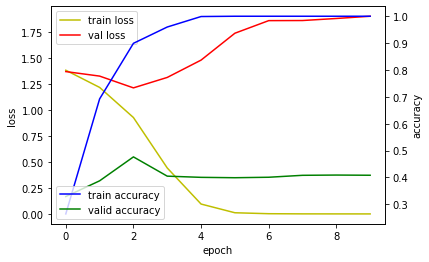

In [42]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist1.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist1.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist1.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

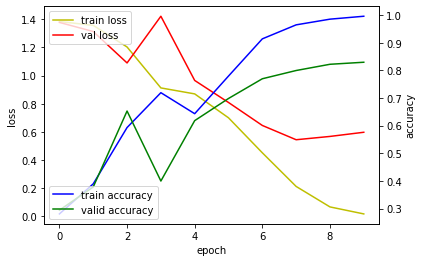

In [43]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist2.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist2.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist2.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist2.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

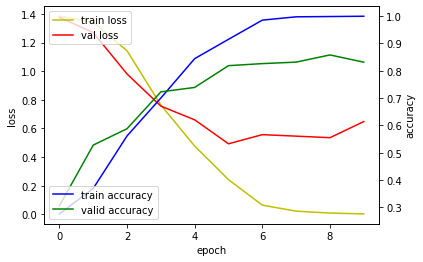

In [44]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist3.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist3.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist3.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist3.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

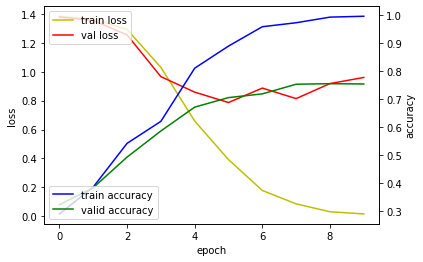

In [45]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist4.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist4.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist4.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist4.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Test

In [46]:
test_data = pd.read_json("~/aiffel/dktc/data/test.json")
test_data = test_data.transpose()
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [47]:
test_corpus = [preprocess_sentence(s) for s in test_data["text"]]
tokenized_test_corpus = []
for idx in range(len(test_corpus)):
    tokenized_test_corpus.append(spm_tokenizer.EncodeAsIds(test_corpus[idx]))
    
X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test_corpus, padding='pre', maxlen=max_len)

In [48]:
predicted1 = model1.predict(X_test)
predicted2 = model2.predict(X_test)
predicted3 = model3.predict(X_test)
predicted4 = model4.predict(X_test)

In [49]:
import numpy as np

predicted1 = np.argmax(predicted1, axis=-1)
predicted2 = np.argmax(predicted2, axis=-1)
predicted3 = np.argmax(predicted3, axis=-1)
predicted4 = np.argmax(predicted4, axis=-1)

## Submission

In [50]:
submission1 = pd.read_csv("~/aiffel/dktc/data/submission.csv")
submission2 = pd.read_csv("~/aiffel/dktc/data/submission.csv")
submission3 = pd.read_csv("~/aiffel/dktc/data/submission.csv")
submission4 = pd.read_csv("~/aiffel/dktc/data/submission.csv")

In [51]:
submission1['class'] = predicted1
submission2['class'] = predicted2
submission3['class'] = predicted3
submission4['class'] = predicted4

In [52]:
submission1.head()
submission2.head()
submission3.head()
submission4.head()

,file_name,class
0,t_000,1
1,t_001,2
2,t_002,3
3,t_004,3
4,t_005,0


In [53]:
submission1.to_csv("SimpleRNN_aug.csv", index=False) ## ACCURACY: 0.245
submission2.to_csv("LSTM_aug.csv", index=False) ## ACCURACY: 0.54
submission3.to_csv("Bidirectional_LSTM_aug.csv", index=False) ## ACCURACY: 0.525
submission4.to_csv("GRU_aug.csv", index=False) ## ACCURACY: 0.42


In [54]:
len(submission1)

400